<a href="https://colab.research.google.com/github/psylanrex/notebooks/blob/master/fv_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp
import tensorflow as tf
from tensorflow import keras
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [0]:
warnings.filterwarnings('ignore')

# Data Prep

In [5]:
fv_series = pd.read_csv('/content/drive/My Drive/Colab Notebooks/re_project/data/Fountain_Valley.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
fv_series.head()

0
1996-04-01    219900.0
1996-05-01    220000.0
1996-06-01    220300.0
1996-07-01    220500.0
1996-08-01    220700.0
Name: 1, dtype: float64

In [6]:
SPLIT_POINT = len(fv_series) - 12
dataset, validation = fv_series[0:SPLIT_POINT], fv_series[SPLIT_POINT:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 261, Validation 12


In [7]:
series = pd.read_csv('/content/dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.head())
print(type(series))

0
1996-04-01    219900.0
1996-05-01    220000.0
1996-06-01    220300.0
1996-07-01    220500.0
1996-08-01    220700.0
Name: 1, dtype: float64
<class 'pandas.core.series.Series'>


In [0]:
data = series.values

In [9]:
train_size = int(len(data) * 0.7)
train_mean = data[:train_size].mean()
train_std = data[:train_size].std()
print('Mean: ', train_mean)
print('STD: ', train_std)

Mean:  475119.23076923075
STD:  174514.1910330955


In [10]:
std_data = (data - train_mean) / train_std
std_data[:5]

array([-1.46245546, -1.46188244, -1.46016338, -1.45901734, -1.4578713 ])

In [11]:
print(type(std_data))

<class 'numpy.ndarray'>


# Helper Functions

In [0]:
def windowedDataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
def makeForecast(model, X, train_size, window_size, time_valid, x_valid):
  forecast = []

  for time in range(len(X) - window_size):
    forecast.append(model.predict(X[time:time + window_size][np.newaxis]))

  forecast = forecast[train_size-window_size:]
  results = np.array(forecast)[:, 0, 0]

  plt.figure(figsize=(10, 6))
  plot_series(time_valid, x_valid)
  plot_series(time_valid, results)

  return results

In [0]:
def modelForecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(7).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [0]:
x_train, x_valid = std_data[0:train_size], std_data[train_size:]
time = np.arange(len(std_data), dtype="float32")
time_train, time_valid = time[0:train_size], time[train_size:]

In [17]:
print(type(x_train))
print(x_train.shape)

<class 'numpy.ndarray'>
(182,)


In [18]:
window_size = 12
batch_size = 7
shuffle_buffer_size = 100

dataset = windowedDataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


In [0]:
scores = {}

# Single Neuron Network

In [20]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model.fit(dataset, epochs=300, verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.49917945],
       [ 0.4704702 ],
       [ 0.08879475],
       [ 0.49924684],
       [-0.56987417],
       [-0.5494476 ],
       [-0.10571708],
       [ 0.5535238 ],
       [-0.2733723 ],
       [ 0.19506486],
       [ 1.0744554 ],
       [ 0.11184766]], dtype=float32), array([-0.00108253], dtype=float32)]


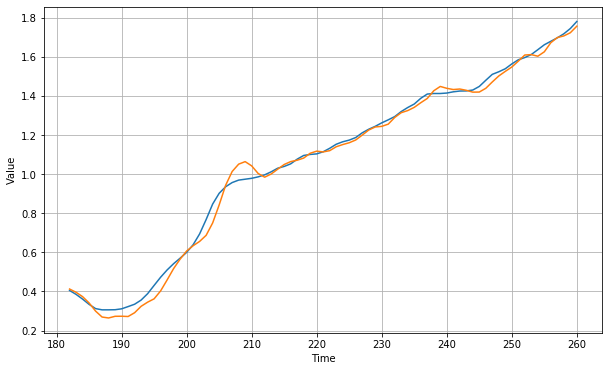

In [21]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [0]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [23]:
scores['SNN'] = score
print(scores)

{'SNN': 0.024300091}


# DNN

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(12, activation='relu'),
  tf.keras.layers.Dense(1)
])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss='mae', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_scheduler], verbose=0)

[1e-05, 0.001, -1, 1]

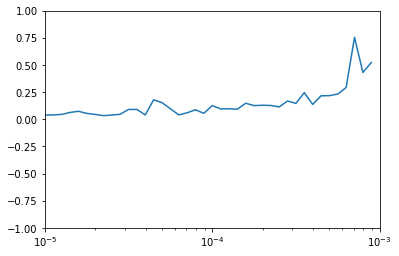

In [25]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5, 1e-3, -1, 1])

In [26]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(12, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(12, activation='relu'),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=9e-3, momentum=0.9)
model.compile(loss='mae', optimizer=optimizer)
model.fit(dataset, epochs=300, verbose=0)

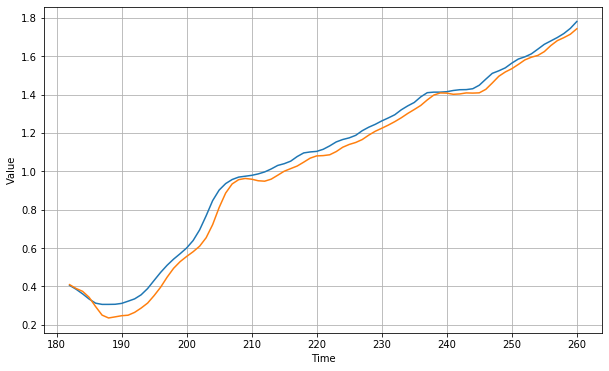

In [27]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [0]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [29]:
scores['DNN'] = score
print(scores)

{'SNN': 0.024300091, 'DNN': 0.040841855}


# Simple LSTM model

In [30]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.LSTM(12, input_shape=[window_size]),
  tf.keras.layers.Dense(1)
])
model.compile(loss='mae', optimizer='adam')
model.fit(dataset, epochs=300, verbose=0)

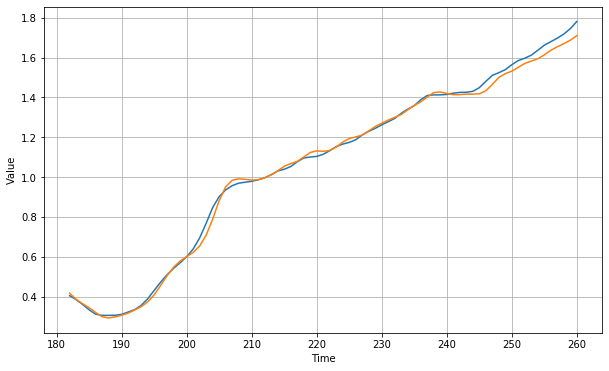

In [31]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [32]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
scores['Single LSTM'] = score
print(scores)

{'SNN': 0.024300091, 'DNN': 0.040841855, 'Single LSTM': 0.017324826}


# RNN

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(24, return_sequences=True),
  tf.keras.layers.SimpleRNN(24),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss='mae', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-05, 0.001, -0.1, 1]

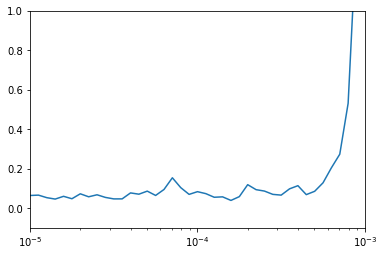

In [34]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5, 1e-3, -0.1, 1])

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(24, return_sequences=True),
  tf.keras.layers.SimpleRNN(24),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=9e-3, momentum=0.9)
model.compile(loss='mae', optimizer=optimizer)
model.fit(dataset, epochs=300, verbose=0)

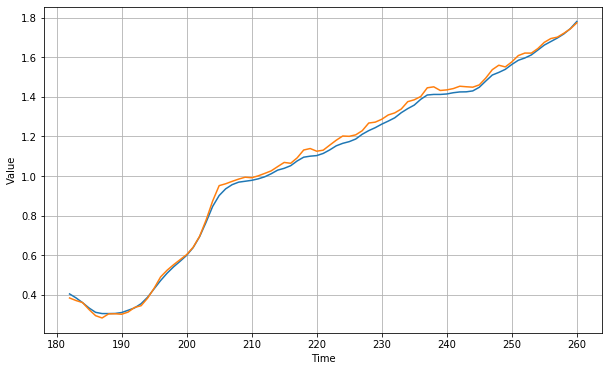

In [36]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [37]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
scores['RNN'] = score
print(scores)

{'SNN': 0.024300091, 'DNN': 0.040841855, 'Single LSTM': 0.017324826, 'RNN': 0.018095529}


In [38]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(24, return_sequences=True),
  tf.keras.layers.SimpleRNN(24),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
model.fit(dataset, epochs=300, verbose=0)

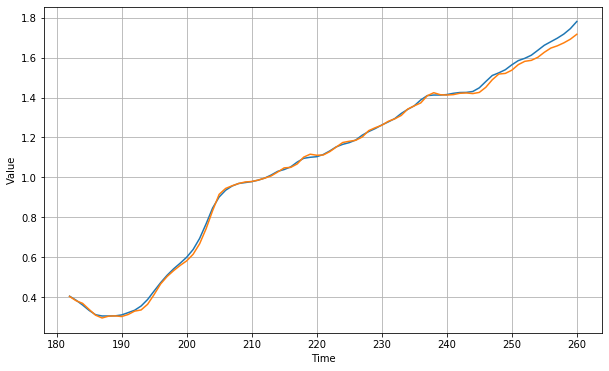

In [39]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [40]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
scores['RNN w. adam optimizer'] = score
print(scores)

{'SNN': 0.024300091, 'DNN': 0.040841855, 'Single LSTM': 0.017324826, 'RNN': 0.018095529, 'RNN w. adam optimizer': 0.011890224}


# Bidirectional LSTM

In [41]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
  tf.keras.layers.Dense(1)
])
model.compile(loss='mae', optimizer='adam')
model.fit(dataset, epochs=300, verbose=0)

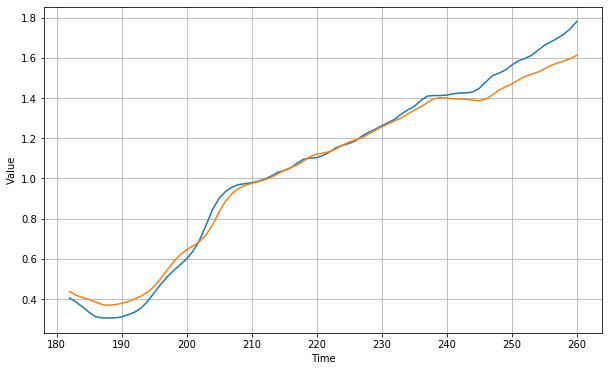

In [42]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [43]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
scores['Bidrectional LSTM w. adam'] = score
print(scores)

{'SNN': 0.024300091, 'DNN': 0.040841855, 'Single LSTM': 0.017324826, 'RNN': 0.018095529, 'RNN w. adam optimizer': 0.011890224, 'Bidrectional LSTM w. adam': 0.043607537}


In [44]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 100**(epoch/20))
model.compile(loss='mae', optimizer=optimizer)
model.fit(dataset, epochs=300, verbose=0, callbacks=[lr_schedule])

[1e-05, 0.001, -0.1, 1]

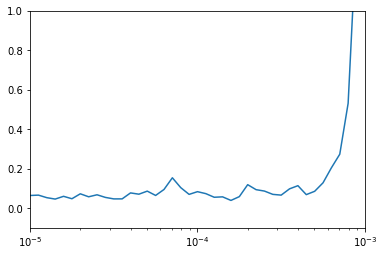

In [45]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5, 1e-3, -0.1, 1])

In [46]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)
model.compile(loss='mae', optimizer=optimizer)
model.fit(dataset, epochs=300, verbose=0)

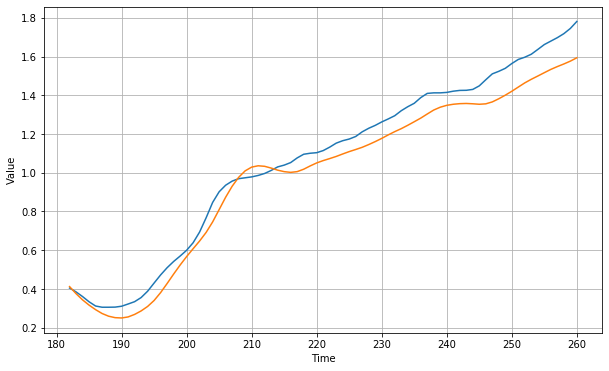

In [47]:
results = makeForecast(model, std_data, train_size, window_size, time_valid, x_valid)

In [48]:
score = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
scores['Bidrectional LSTM w. sgd'] = score
print(scores)

{'SNN': 0.024300091, 'DNN': 0.040841855, 'Single LSTM': 0.017324826, 'RNN': 0.018095529, 'RNN w. adam optimizer': 0.011890224, 'Bidrectional LSTM w. adam': 0.043607537, 'Bidrectional LSTM w. sgd': 0.07728435}


# Final model - RNN with adam optimizer

In [0]:
best_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(24, return_sequences=True),
  tf.keras.layers.SimpleRNN(24),
  tf.keras.layers.Dense(1)
])

best_model.compile(loss='mae', optimizer='adam')

In [0]:
final_hist = best_model.fit(dataset, epochs=300, verbose=0)

In [0]:
test_series = pd.read_csv('/content/validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

In [89]:
test_series.head()

0
2018-01-01    792900.0
2018-02-01    798300.0
2018-03-01    801600.0
2018-04-01    803700.0
2018-05-01    806200.0
Name: 1, dtype: float64

In [0]:
test_data = test_series.values

In [91]:
print(test_data)

[792900. 798300. 801600. 803700. 806200. 809800. 813900. 818100. 818300.
 817500. 817300. 819000.]


In [92]:
std_test_data = (test_data - train_mean) / train_std
print(std_test_data)

[1.82094515 1.85188819 1.87079783 1.88283123 1.89715671 1.91778541
 1.9412792  1.96534601 1.96649205 1.9619079  1.96076186 1.97050318]


In [0]:
# np.insert(std_test_data, 0, std_data[-1])
# std_test_data = std_test_data[:-1]
# print(std_test_data)

In [81]:
processed_test_data = np.asarray(std_test_data)
print(type(processed_test_data))
print(processed_test_data.shape)
# print(dataset.shape)
windowed_test_data = windowedDataset(processed_test_data, window_size, batch_size, shuffle_buffer_size)

<class 'numpy.ndarray'>
(12,)


In [66]:
print(windowed_test_data)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


In [0]:
for t in windowed_test_data:
  print(t.numpy())

In [58]:
for d in dataset.take(1):
  print(d)

(<tf.Tensor: shape=(7, 12), dtype=float64, numpy=
array([[-1.43151241, -1.42750128, -1.42291712, -1.41718693, -1.40973768,
        -1.40171541, -1.39140106, -1.37936766, -1.36561519, -1.34899763,
        -1.33123404, -1.31461648],
       [-0.88255992, -0.8642233 , -0.84474065, -0.82296591, -0.80119118,
        -0.77998947, -0.75993379, -0.74102415, -0.72211452, -0.70263186,
        -0.6831492 , -0.66309353],
       [ 0.96084317,  0.98433697,  1.0032466 ,  1.0238753 ,  1.04736909,
         1.07315496,  1.10295196,  1.13504104,  1.16999522,  1.20953355,
         1.25308302,  1.29892456],
       [-0.91522202, -0.8997505 , -0.88255992, -0.8642233 , -0.84474065,
        -0.82296591, -0.80119118, -0.77998947, -0.75993379, -0.74102415,
        -0.72211452, -0.70263186],
       [-1.44984903, -1.44526488, -1.43953468, -1.43437751, -1.43151241,
        -1.42750128, -1.42291712, -1.41718693, -1.40973768, -1.40171541,
        -1.39140106, -1.37936766],
       [-0.4722781 , -0.44534619, -0.41612221

In [0]:
# forecast = modelForecast(best_model, windowed_test_data, window_size)
forecast = best_model.predict(std_test_data)

In [73]:
test_time = []
for i in range(len(test_series)):
  test_time.append(i)

test_time = np.array(test_time)
print(test_time)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [94]:
print(forecast)

[[2.4602337]
 [2.4793134]
 [2.4907198]
 [2.4978795]
 [2.5063047]
 [2.5182514]
 [2.531595 ]
 [2.54498  ]
 [2.5456102]
 [2.543085 ]
 [2.5424526]
 [2.5478113]]


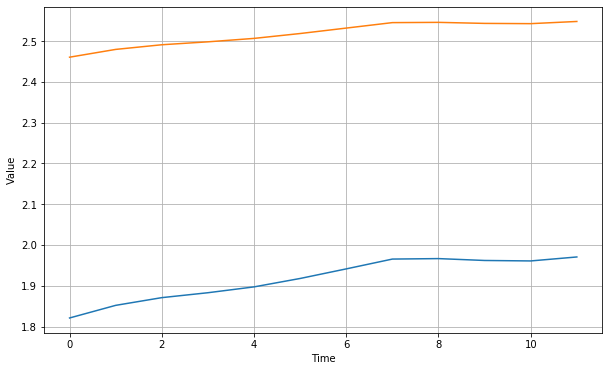

In [117]:
plt.figure(figsize=(10,6))
plot_series(test_time, std_test_data)
plot_series(test_time, forecast)

In [0]:
reversed_test_data = (train_std * std_test_data) + train_mean
reversed_forecast = (train_std * forecast) + train_mean

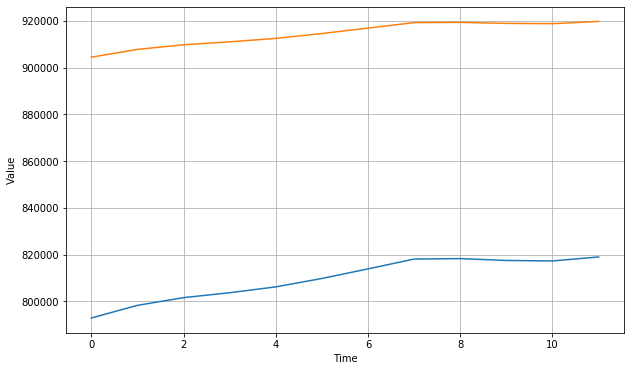

In [97]:
plt.figure(figsize=(10,6))
plot_series(test_time, reversed_test_data)
plot_series(test_time, reversed_forecast)

In [103]:
for t in range(len(test_series.index)):
  print('For {}: predicted = {}, actual = {}'.format(test_series.index[t], reversed_forecast[t][0], reversed_test_data[t]))

For 2018-01-01 00:00:00: predicted = 904464.875, actual = 792900.0
For 2018-02-01 00:00:00: predicted = 907794.5625, actual = 798300.0
For 2018-03-01 00:00:00: predicted = 909785.125, actual = 801600.0
For 2018-04-01 00:00:00: predicted = 911034.625, actual = 803700.0
For 2018-05-01 00:00:00: predicted = 912505.0, actual = 806200.0
For 2018-06-01 00:00:00: predicted = 914589.8125, actual = 809800.0
For 2018-07-01 00:00:00: predicted = 916918.5, actual = 813900.0
For 2018-08-01 00:00:00: predicted = 919254.375, actual = 818100.0
For 2018-09-01 00:00:00: predicted = 919364.3125, actual = 818300.0
For 2018-10-01 00:00:00: predicted = 918923.625, actual = 817500.0
For 2018-11-01 00:00:00: predicted = 918813.25, actual = 817300.0
For 2018-12-01 00:00:00: predicted = 919748.4375, actual = 819000.0


In [0]:
gap = np.subtract(forecast[0], std_test_data).mean()

In [121]:
print(gap)

0.5429257954165382


In [123]:
adj_forecast = forecast - gap
print(adj_forecast)

[[1.9173079]
 [1.9363875]
 [1.947794 ]
 [1.9549537]
 [1.9633789]
 [1.9753256]
 [1.9886692]
 [2.0020542]
 [2.0026844]
 [2.0001593]
 [1.9995267]
 [2.0048854]]


In [0]:
reversed_adj_forecast = (train_std * adj_forecast) + train_mean

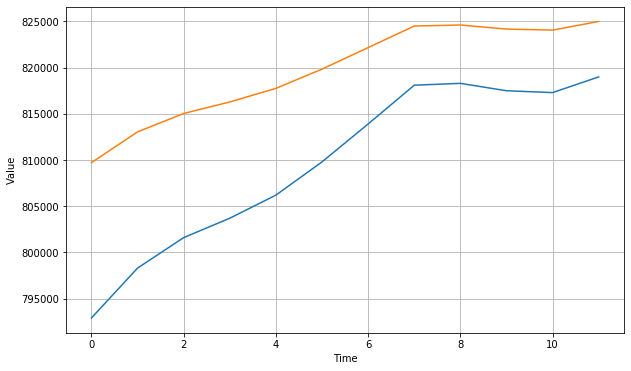

In [125]:
plt.figure(figsize=(10,6))
plot_series(test_time, reversed_test_data)
plot_series(test_time, reversed_adj_forecast)